In [2]:
#if saved workspace exists
import dill                         
filename = 'globalsave.pkl'
dill.load_session(filename)

In [2]:
import dill
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
import sklearn

In [3]:
#show all data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
#increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#load training and test data and concatenate into alldata for later analysis
rawtrain = pd.read_csv('D:\\Users\\danielle.regala\\Documents\\Projects\\MachineLearning\\House Prices - Regression\\train.csv')
rawtest = pd.read_csv("D:\\Users\\danielle.regala\\Documents\\Projects\\MachineLearning\\House Prices - Regression\\test.csv")

In [6]:
train_nrows = rawtrain.shape[0] #1460
test_nrows = rawtest.shape[0] #1459

## The target variable


In [ ]:
#Distribution, skewness, and kurtosis
sns.catplot(y='SalePrice',kind='box',data=rawtrain)
plt.show()

rawtrain['SalePrice'].describe()

In [ ]:
sns.distplot(rawtrain['SalePrice'], kde=True, rug=False);
(rawtrain['SalePrice']).skew()

In [ ]:
rawtrain['SalePrice'].kurtosis()

In [ ]:
#normality
scipy.stats.probplot(rawtrain['SalePrice'], plot=plt)
plt.show()

SalePrice is positively skewed with high kurtosis. Also, SalePrice is not normal, so must be transformed.

### Checking target variable's skewness, normality and kurtosis, assumptions of LR on independent features, and outliers

In [ ]:
#Table of skewness and kurtosis to check normality
SkewKurt = pd.DataFrame()

for feat in list(rawtrain):
    if rawtrain[feat].dtypes == 'int64' or rawtrain[feat].dtypes == 'float64': 
        fskew = rawtrain[feat].skew()
        fkurt = rawtrain[feat].kurtosis()
        SkewKurt.loc[feat,'Kurtosis'] = fkurt
        SkewKurt.loc[feat,'Skewness'] = fskew

Variables that are non-normal (high skewness and kurtosis): Lotfrontage,LotArea, MasVnrArea,BsmtFinSF1,BsmtFinSF2, TotalBsmtSF, 1stFlrSF,LowQualFinSF,GrLivArea,OpenPorchSF,EnclosedPorch,3SsnPorch,PoolArea,MiscVal

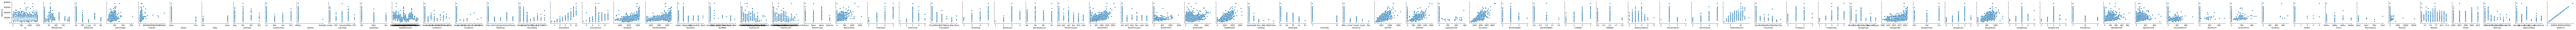

In [8]:
#Check linearity of independent features with target variable. And check for outliers
sns.pairplot(rawtrain, y_vars=['SalePrice'],x_vars = list(rawtrain))

In [ ]:
#looking for the outliers

#rawtrain[rawtrain['LotFrontage']>300] #934 ($242K) and 1298 ($160K)
#rawtrain[rawtrain['LotArea']>100000] #249,313,335,706
#rawtrain[rawtrain['BsmtFinSF1']>1800] #1298, 70,523
#rawtrain[rawtrain['TotalBsmtSF']>6000] #1298
#rawtrain[rawtrain['1stFlrSF']>3000] #496,523,1298
#rawtrain[rawtrain['GrLivArea']>4000] #523,1298
#rawtrain[rawtrain['LowQualFinSF']>550] #185
#rawtrain[rawtrain['GarageArea']>1200] #581,1061,1190,1298
#rawtrain[rawtrain['OpenPorchSF']>400] #495
#rawtrain[rawtrain['PoolArea']>400] #1182

Since records 523 and 1298 were outliers twice, we drop them.

In [113]:
rawtrain.drop([523,1298],inplace=True)
train_nrows = train_nrows-2 #1460

In [134]:
#Check data balance using scatterplots above.
# Street and Utilities show the highest imbalance.

In [3]:
#Combine train and test data
alldata = pd.concat([rawtrain.loc[:,rawtrain.columns!='SalePrice'],rawtest])

## Combined training and test data

In [4]:
#Reset index for easier indexing
alldata = alldata.reset_index(drop=True)

In [5]:
#Standardizing ratings to Po,Fa,TA,Gd,Ex
for feat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual','FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']:
    alldata[feat].replace({5:'Ex',4:'Gd',3:'TA',1:'Po',2:'Fa'},inplace=True)

#Houses from training data with no pool had PoolQC of 'Po'
alldata.loc[alldata[alldata['PoolArea']==0].index,'PoolQC']='NoPool'



### Missing data 

In [147]:
# How many missing data?
missing = alldata.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
PoolQC             3
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
Exterior2nd        1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

In [148]:
#Fill in missing data
alldata['MiscFeature'].fillna(value= 'NoMisc',inplace=True)
alldata['Alley'].fillna(value= 'NoAlley',inplace=True)
alldata['Fence'].fillna(value= 'NoFence',inplace=True)
alldata['PoolQC'].fillna(value= 'NoPool',inplace=True)
alldata['FireplaceQu'].fillna(value= 'NoFireplace',inplace=True)
alldata['LotFrontage'].fillna(value= 0,inplace=True)
alldata['GarageCond'].fillna(value= 'NoGarage',inplace=True) #157 houses have no Garages
alldata['GarageQual'].fillna(value= 'NoGarage',inplace=True)
alldata['GarageYrBlt'].fillna(value= 'NoGarage',inplace=True)
alldata['GarageFinish'].fillna(value= 'NoGarage',inplace=True)
alldata['GarageType'].fillna(value= 'NoGarage',inplace=True)
alldata.loc[list(alldata[alldata[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtExposure'] = alldata.loc[list(alldata[alldata[['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtExposure'].fillna(value='NoBsmt')
alldata.loc[list(alldata[alldata[['BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtCond']= alldata.loc[list(alldata[alldata[['BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtCond'].fillna(value='NoBsmt')
alldata.loc[list(alldata[alldata[['BsmtQual','BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtQual']= alldata.loc[list(alldata[alldata[['BsmtQual','BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtQual'].fillna(value='NoBsmt')
alldata.loc[list(alldata[alldata[['BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtFinType1']= alldata.loc[list(alldata[alldata[['BsmtFinType1','BsmtFinType2']].isnull().all(axis=1)].index),'BsmtFinType1'].fillna(value='NoBsmt')
alldata.loc[list(alldata[alldata[['BsmtFinType2']].isnull().all(axis=1)].index),'BsmtFinType2'] = alldata.loc[list(alldata[alldata[['BsmtFinType2']].isnull().all(axis=1)].index),'BsmtFinType2'].fillna(value='NoBsmt')
alldata.loc[list(alldata[alldata[['MasVnrType','MasVnrArea']].isnull().all(axis=1)].index),'MasVnrType'] = alldata.loc[list(alldata[alldata[['MasVnrType','MasVnrArea']].isnull().all(axis=1)].index),'MasVnrType'].fillna(value='NoMason')
alldata['MasVnrArea'].fillna(value= 0,inplace=True)
alldata['MSZoning'].fillna(value= 'RL',inplace=True)
alldata['BsmtExposure'].fillna(value= 'No',inplace=True)
alldata['BsmtCond'].fillna(value= 'TA',inplace=True)
alldata['Functional'].fillna(value= 'Typ',inplace=True)
alldata['BsmtFullBath'].fillna(value= 0,inplace=True) #these records have no basements
alldata['BsmtHalfBath'].fillna(value= 0,inplace=True) #these records have no basements
alldata['BsmtQual'].fillna(value= 'TA',inplace=True) #the mode for all houses with completely unfinished basements and No Exposure basements. Also these houses' OverallQual is 4 and ExterQual is TA
alldata['Utilities'].fillna(value= 'AllPub',inplace=True) #mode
alldata['KitchenQual'].fillna(value= 'TA',inplace=True) #mode
alldata['BsmtFinSF2'].fillna(value= 0,inplace=True) #No basement
alldata['BsmtFinSF1'].fillna(value= 0,inplace=True) #No basement
alldata['BsmtUnfSF'].fillna(value= 0,inplace=True) #No basement
alldata['TotalBsmtSF'].fillna(value= 0,inplace=True) #No basement
alldata['SaleType'].fillna(value= 'WD',inplace=True) #mode
alldata['Electrical'].fillna(value= 'SBrkr',inplace=True) #mode
alldata['SaleType'].fillna(value= 'WD',inplace=True) #mode
#1 house with completely no data on Garages
alldata['GarageArea'].fillna(value= alldata[(alldata["GarageType"] == 'Detchd') & (alldata["GarageCars"] == 2)]['GarageArea'].mean(),inplace=True) #The mean area for garages with Detchd type and 2 cars
alldata['GarageCars'].fillna(value=2,inplace=True) #mode for Detchd garages

In [149]:
#2 houses with Garages but no other info aside from GarageType (Detached)
alldata.loc[[2124,2574],'GarageCond']=alldata['GarageCond'].mode()[0]
alldata.loc[[2124,2574],'GarageQual']=alldata['GarageQual'].mode()[0]
alldata.loc[[2124],'GarageFinish']=alldata[(alldata["GarageType"] == 'Detchd') & (alldata["GarageCars"] == 1)]['GarageFinish'].mode()[0]
alldata.loc[[2574],'GarageFinish']=alldata[(alldata["GarageType"] == 'Detchd') & (alldata["GarageCars"] == 2)]['GarageFinish'].mode()[0]
alldata.loc[[2124],'GarageYrBlt']=alldata[(alldata["GarageType"] == 'Detchd') & (alldata["GarageCars"] == 1)]['GarageYrBlt'].mode()[0]
alldata.loc[[2574],'GarageYrBlt']=alldata[(alldata["GarageType"] == 'Detchd') & (alldata["GarageCars"] == 2)]['GarageYrBlt'].mode()[0]
alldata[alldata['Id'].isin([2127,2577])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NoFireplace,Detchd,1920,Unf,1.0,360.000000,TA,TA,Y,64,0,180,0,0,0,NoPool,MnPrv,Shed,1000,9,2008,WD,Normal
2574,2577,70,RM,50.0,9060,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NoFireplace,Detchd,1999,Unf,2.0,529.575521,TA,TA,Y,174,0,212,0,0,0,NoPool,MnPrv,NoMisc,0,3,2007,WD,Alloca


In [150]:
#Fill all other missing data with modes
alldata['Exterior1st'].fillna(value='VinylSd',inplace=True)
alldata['Exterior2nd'].fillna(value='VinylSd',inplace=True)
alldata['MasVnrType'].fillna(value='None',inplace=True)

missing = alldata.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

### Feature Engineering

In [121]:
#Combine Condition 1 and 2 to check whether house is near each type of off-site
#How much area of each basement finish type? Remove Unf type because there's already a separate feature for UnfSF
#Total Area = GrLivArea + TotalBsmtSF + GarageArea
#Combine Exterior1st and Exterior2nd
#Combine misc
#Total bathrooms

In [151]:
#Combine Condition 1 and 2 to check how many of each off-site a house is near to
#Norm is considered no off-sites

temp=alldata[['Condition1','Condition2']]
temp = pd.get_dummies(temp)
temp = temp.drop(['Condition1_Norm'],axis=1)
temp = temp.drop(['Condition2_Norm'],axis=1)

for feat in ['Artery','Feedr','RRNn','RRAn','PosN','PosA','RRAe']: #RRNe not included because it is not listed under Condition 2
    cond1 = 'Condition1_'+feat
    cond2 = 'Condition2_'+feat
    newcond = 'Condition_'+feat
    temp[newcond] = temp[cond1] + temp[cond2]
    temp = temp.drop([cond1],axis=1)
    temp = temp.drop([cond2],axis=1)
    
temp = temp.rename({'Condition1_RRNe':'Condition_RRNe'},axis='columns')
alldata = pd.concat([alldata, temp],axis=1)
alldata= alldata.drop(['Condition1'],axis=1)
alldata = alldata.drop(['Condition2'],axis=1) 

In [152]:
#How much area of each basement finish type? Remove Unf type because there's already a separate feature for UnfSF
Type1 = alldata.pivot(columns='BsmtFinType1', values='BsmtFinSF1')
Type2= alldata.pivot(columns='BsmtFinType2', values='BsmtFinSF2')
Type1.fillna(0,inplace=True)
Type2.fillna(0,inplace=True)

for feat in ['GLQ','ALQ','BLQ','Rec','LwQ','Unf']:    
    alldata['Bsmt'+feat] = Type1[feat] + Type2[feat]

#drop unnecessary columns
alldata=alldata.drop('BsmtUnf',axis=1)
alldata=alldata.drop('BsmtFinType1',axis=1)
alldata=alldata.drop('BsmtFinType2',axis=1)
alldata=alldata.drop('BsmtFinSF1',axis=1)
alldata=alldata.drop('BsmtFinSF2',axis=1)

In [153]:
#Get Total Area per house = GrLivArea + TotalBsmtSF + GarageArea
alldata['TotalFlrArea'] = alldata['GrLivArea']+alldata['TotalBsmtSF']+alldata['GarageArea']

In [154]:
#typo
alldata.replace(to_replace = 'CmentBd',value='CemntBd',inplace=True)
alldata.replace(to_replace = 'Brk Cmn',value='BrkComm',inplace=True)
alldata.replace(to_replace = 'Wd Shng',value='WdShing',inplace=True)

In [155]:
#Combine Exterior1st and Exterior2nd
temp1 = pd.get_dummies(alldata['Exterior1st'])
temp2 = pd.get_dummies(alldata['Exterior2nd'])

#add columns
for feat in list(temp1):
    alldata['Exterior_'+feat] = temp1[feat] + temp2[feat]
    alldata['Exterior_'+feat] = alldata['Exterior_'+feat].replace(to_replace = 2, value=1)

In [156]:
#Exteriors that are only in Exterior1st
temp = pd.get_dummies(alldata['Exterior2nd'])
alldata=pd.concat([alldata,temp['Other']],axis=1)

In [157]:
#drop unnecessary columns
alldata = alldata.drop('Exterior1st',axis=1)
alldata = alldata.drop('Exterior2nd',axis=1)

In [158]:
#Combine Misc features
temp = alldata.pivot(columns='MiscFeature', values='MiscVal')
temp = temp.drop('NoMisc',axis=1)
temp.fillna(value= 0,inplace=True)

for feat in list(temp):
    alldata['Misc'+feat] = temp[feat]

#drop unnecessary columns
alldata=alldata.drop('MiscFeature',axis=1)
alldata=alldata.drop('MiscVal',axis=1)

In [159]:
#Number of bathrooms
alldata['TotalBath'] = alldata['BsmtFullBath']+alldata['FullBath']+0.5*alldata['BsmtHalfBath']+0.5*alldata['HalfBath']

#### Binning

##### Neigborhood and MSZoning

In [160]:
#Create the Zoning and Neighborhood bins
alldata['ZoneHood'] = alldata['MSZoning']+alldata['Neighborhood']
temp_ZoneHood = alldata.iloc[:train_nrows,:]
rawSP =pd.DataFrame(rawtrain['SalePrice'].values.reshape(-1,1)) 
temp_ZoneHood = pd.concat([temp_ZoneHood,rawSP],axis=1)
temp_ZoneHood =temp_ZoneHood[['ZoneHood',0]] 
temp_ZoneHood_desc = temp_ZoneHood.groupby('ZoneHood').describe().sort_values(by=(0,'50%'))

In [161]:
#Bin based on neighborhood median sale price
dmax =np.amax(temp_ZoneHood_desc[(0,'50%')])
dmin = np.amin(temp_ZoneHood_desc[(0,'50%')])
diff= dmax - dmin
Price_1 = list(temp_ZoneHood_desc.loc[temp_ZoneHood_desc[(0,'50%')]<dmin+(0.167*diff),:].index)
Price_2 = list(temp_ZoneHood_desc.loc[(temp_ZoneHood_desc[(0,'50%')]<dmin+(0.33*diff)) & (dmin+(0.167*diff)<=temp_ZoneHood_desc[(0,'50%')])].index)
Price_3 = list(temp_ZoneHood_desc.loc[(temp_ZoneHood_desc[(0,'50%')]<dmin+(0.5*diff)) & (dmin+(0.33*diff)<=temp_ZoneHood_desc[(0,'50%')])].index)
Price_4 = list(temp_ZoneHood_desc.loc[(temp_ZoneHood_desc[(0,'50%')]<dmin+(0.67*diff)) & (dmin+(0.5*diff)<=temp_ZoneHood_desc[(0,'50%')])].index)
Price_5 = list(temp_ZoneHood_desc.loc[(temp_ZoneHood_desc[(0,'50%')]<dmin+(0.83*diff)) & (dmin+(0.67*diff)<=temp_ZoneHood_desc[(0,'50%')])].index)
Price_6 = list(temp_ZoneHood_desc.loc[(temp_ZoneHood_desc[(0,'50%')]<=dmin+(diff)) & (dmin+(0.83*diff)<=temp_ZoneHood_desc[(0,'50%')])].index)

In [162]:
#apply the logic to the dataframe
conditions = [
    (alldata['ZoneHood'].isin(Price_1)),
    (alldata['ZoneHood'].isin(Price_2)),
    (alldata['ZoneHood'].isin(Price_3)),
    (alldata['ZoneHood'].isin(Price_4)),
     (alldata['ZoneHood'].isin(Price_5)),
    (alldata['ZoneHood'].isin(Price_6)),
    
]
choices = ['ZH1', 'ZH2', 'ZH3','ZH4','ZH5','ZH6']
alldata['ZH_Price_bucket'] = np.select(conditions, choices)
# alldata = alldata.drop(['ZoneHood','MSZoning','Neighborhood'],axis=1)

In [284]:
alldata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Condition_RRNe,Condition_Artery,Condition_Feedr,Condition_RRNn,Condition_RRAn,Condition_PosN,Condition_PosA,Condition_RRAe,BsmtGLQ,BsmtALQ,BsmtBLQ,BsmtRec,BsmtLwQ,TotalFlrArea,Exterior_AsbShng,Exterior_AsphShn,Exterior_BrkComm,Exterior_BrkFace,Exterior_CBlock,Exterior_CemntBd,Exterior_HdBoard,Exterior_ImStucc,Exterior_MetalSd,Exterior_Plywood,Exterior_Stone,Exterior_Stucco,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing,Other,MiscGar2,MiscOthr,MiscShed,MiscTenC,TotalBath,ZoneHood,ZH_Price_bucket
0,1,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,7,5,2003,2003,Gable,CompShg,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NoFireplace,Attchd,2003,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NoPool,NoFence,2,2008,WD,Normal,0,0,0,0,0,0,0,0,706.0,0.0,0.0,0.0,0.0,3114.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,3.5,RLCollgCr,ZH4
1,2,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,1Fam,1Story,6,8,1976,1976,Gable,CompShg,None,0.0,TA,TA,CBlock,Gd,TA,Gd,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NoPool,NoFence,5,2007,WD,Normal,0,0,1,0,0,0,0,0,0.0,978.0,0.0,0.0,0.0,2984.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.5,RLVeenker,ZH4
2,3,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,7,5,2001,2002,Gable,CompShg,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NoPool,NoFence,9,2008,WD,Normal,0,0,0,0,0,0,0,0,486.0,0.0,0.0,0.0,0.0,3314.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,3.5,RLCollgCr,ZH4
3,4,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,1Fam,2Story,7,5,1915,1970,Gable,CompShg,None,0.0,TA,TA,BrkTil,TA,Gd,No,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NoPool,NoFence,2,2006,WD,Abnorml,0,0,0,0,0,0,0,0,0.0,216.0,0.0,0.0,0.0,3115.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0.0,0.0,2.0,RLCrawfor,ZH4
4,5,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,1Fam,2Story,8,5,2000,2000,Gable,CompShg,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NoPool,NoFence,12,2008,WD,Normal,0,0,0,0,0,0,0,0,655.0,0.0,0.0,0.0,0.0,4179.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,3.5,RLNoRidge,ZH6


##### MSSubClass

In [163]:
SC_temp = alldata.iloc[:train_nrows,:]
rawSP =pd.DataFrame(rawtrain['SalePrice'].values.reshape(-1,1)) 
SC_temp = pd.concat([SC_temp,rawSP],axis=1)
SC_temp = SC_temp[['MSSubClass',0]]
SC_temp = SC_temp[['MSSubClass',0]].groupby('MSSubClass').describe().sort_values(by=(0,'50%'))
SC_temp

0                                                                                
            count           mean            std       min       25%       50%       75%       max
MSSubClass                                                                                       
180          10.0  102300.000000   29474.282575   75500.0   81875.0   88500.0  128000.0  148000.0
30           69.0   95829.724638   24857.110083   34900.0   81000.0   99900.0  110500.0  163500.0
45           12.0  108591.666667   20231.723889   76000.0   94125.0  107500.0  122250.0  139400.0
190          30.0  129613.333333   35439.097670   55000.0  108875.0  128250.0  143750.0  228950.0
50          144.0  143302.972222   54851.983707   37900.0  114125.0  132000.0  159000.0  410000.0
90           52.0  133541.076923   27833.249197   82000.0  118375.0  135980.0  145000.0  206300.0
85           20.0  147810.000000   19629.942220  123000.0  134350.0  140750.0  158375.0  198500.0
40            4.0  156125.000000   75747.799748   79500.0  119625.0  142500.0  179000.0  260000.0
160          63.0  138647.380952   34587.542266   75000.0  114000.0  146000.0  164850.0  239000.0
70           60.0  166772.416667   58206.545762   40000.0  128000.0  156000.0  189500.0  359100.0
20          536.0  185224.811567   78782.189967   35311.0  132500.0  159250.0  220000.0  611657.0
75           16.0  192437.500000  100556.762577  101000.0  125625.0  163500.0  219625.0  475000.0
80           58.0  169736.551724   38197.808771  107000.0  147250.0  166500.0  179425.0  345000.0
120          87.0  200779.080460   58221.490909   99500.0  158050.0  192000.0  232000.0  392500.0
60          297.0  240403.542088   86686.994146  129000.0  185000.0  216000.0  269500.0  755000.0

In [164]:
dmax =np.amax(SC_temp[(0,'50%')])
dmin = np.amin(SC_temp[(0,'50%')])
diff= dmax - dmin
Price_1 = list(SC_temp.loc[SC_temp[(0,'50%')]<dmin+(0.25*diff),:].index)
Price_2 = list(SC_temp.loc[(SC_temp[(0,'50%')]<dmin+(0.50*diff)) & (dmin+(0.25*diff)<=SC_temp[(0,'50%')])].index)
Price_3 = list(SC_temp.loc[(SC_temp[(0,'50%')]<dmin+(0.75*diff)) & (dmin+(0.50*diff)<=SC_temp[(0,'50%')])].index)
Price_4 = list(SC_temp.loc[(SC_temp[(0,'50%')]<=dmin+(diff)) & (dmin+(0.75*diff)<=SC_temp[(0,'50%')])].index)
# Price_5 = list(SC_temp.loc[(SC_temp[(0,'50%')]<dmin+(0.83*diff)) & (dmin+(0.67*diff)<=SC_temp[(0,'50%')])].index)
# Price_6 = list(SC_temp.loc[(SC_temp[(0,'50%')]<=dmin+(diff)) & (dmin+(0.83*diff)<=SC_temp[(0,'50%')])].index)

In [165]:
conditions = [
    (alldata['MSSubClass'].isin(Price_1)),
    (alldata['MSSubClass'].isin(Price_2)),
    (alldata['MSSubClass'].isin(Price_3)),
    (alldata['MSSubClass'].isin(Price_4))
]
choices = ['MS1', 'MS2', 'MS3','MS4']
alldata['MS_Price_bucket'] = np.select(conditions, choices)
alldata = alldata.drop('MSSubClass',axis=1)

### Correcting 

#### Unbalanced 
and unnecessary features

In [166]:
alldata=alldata.drop('Utilities',axis=1)
alldata = alldata.drop('Id',axis=1)

#Possible Unbalanced:RoofStyle, Utilities -- yes!, Street (99%) -- yes!, May remove: CentralAir (93%), Heating (97%), Electrical(91%), GarageQual(95%), 

#### Correlated Features

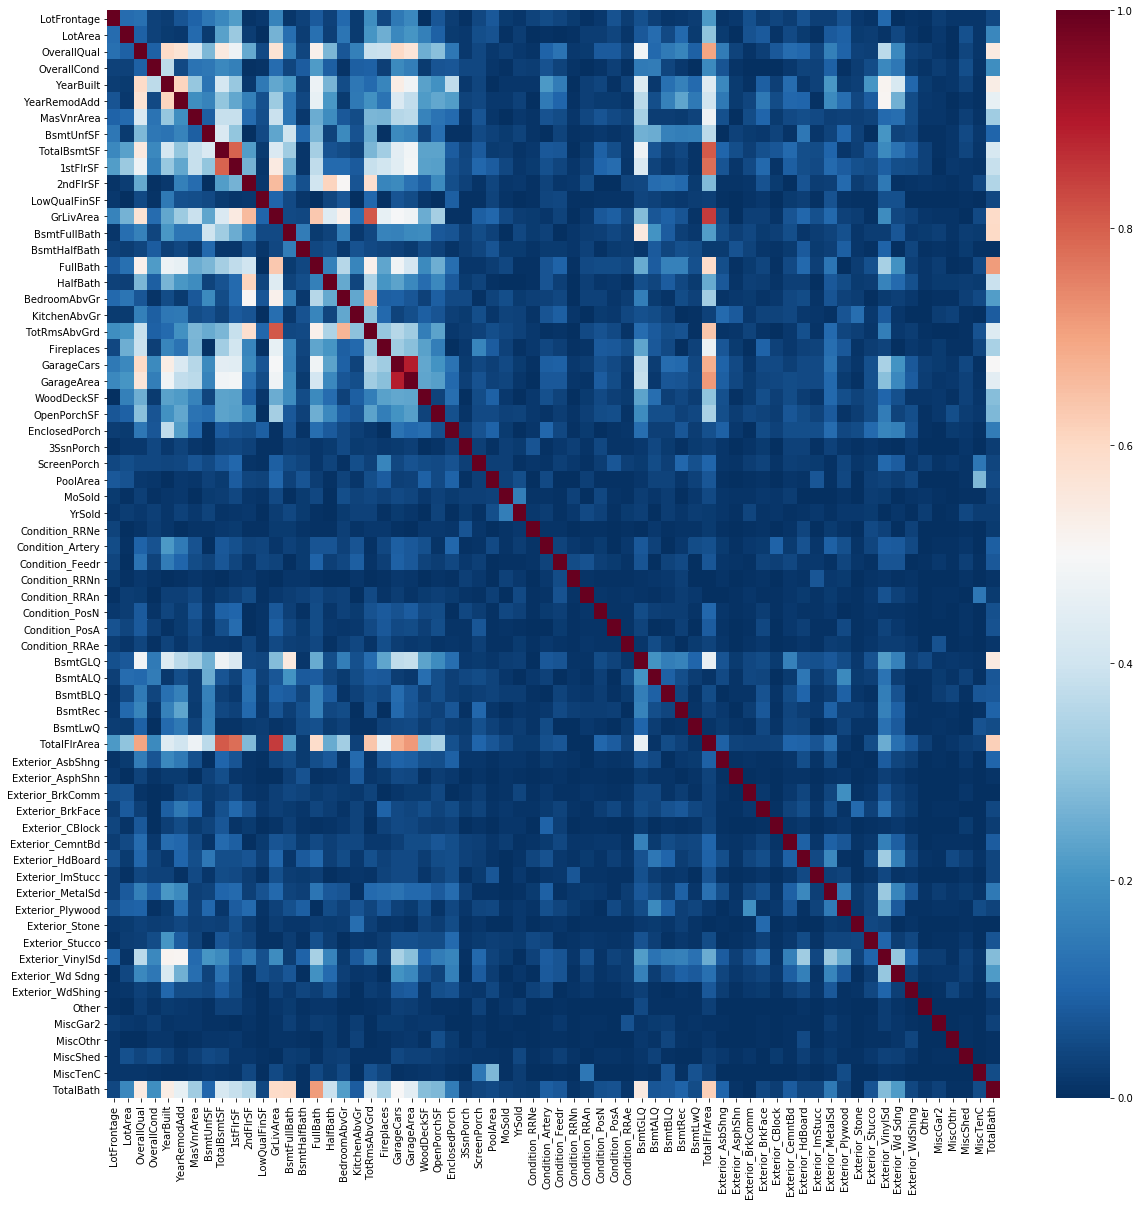

In [363]:
corr= alldata.corr()
corr=pd.DataFrame.abs(corr)
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(corr,ax=ax, cmap="RdBu_r")

High correlation:
-1stFlrSF & TotBsmtSF
-GarageCars & GarageArea
-TotRmsAbvGrd & GrLivArea
-TotalFlrArea & GrLivArea, TotBsmtSF,1stFlrSF

In [167]:
#Remove 1stFlrSF and GarageArea
alldata=alldata.drop(['1stFlrSF','GarageArea'],axis=1)

#### Create age variables

In [168]:
alldata['BuildAge'] = 2019 - alldata['YearBuilt'].astype('int')
alldata['RemodAge'] = 2019 - alldata['YearRemodAdd'].astype('int')
alldata['GarageYrBlt'].replace(to_replace = 'NoGarage',value=2019,inplace=True)
alldata['GarageAge'] = 2019 - alldata['GarageYrBlt'].astype('int')
alldata['SaleAge'] = 2019 - alldata['YrSold'].astype('int')
alldata.drop('YrSold',axis=1,inplace=True)
alldata.drop('YearBuilt',axis=1,inplace=True)
alldata.drop('YearRemodAdd',axis=1,inplace=True)
alldata.drop('GarageYrBlt',axis=1,inplace=True)

### Convert to dummy variables

In [169]:
# alldata['MSSubClass'] = alldata['MSSubClass'].astype('object')
alldata['OverallQual'] = alldata['OverallQual'].astype('object')
alldata['OverallCond'] = alldata['OverallCond'].astype('object')
temp = pd.get_dummies(alldata[['MSZoning','Neighborhood','ZoneHood','MSSubclass''Street', 'Alley', 'RoofMatl','LotShape','LandContour','LotConfig','LandSlope','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle',
             'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
             'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MoSold','SaleType','SaleCondition','ZH_Price_bucket','MS_Price_bucket']])

for feat in ['MSZoning','Neighborhood','ZoneHood','Street', 'Alley', 'RoofMatl','LotShape','LandContour','LotConfig','LandSlope','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle',
             'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
             'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MoSold','SaleType','SaleCondition','ZH_Price_bucket','MS_Price_bucket']:
    alldata.drop(feat,axis=1,inplace=True)

alldata = pd.concat([alldata,temp],axis=1)

### Transform skewed variables

In [170]:
#transform non-binary variables with high skewness
positiveskew = alldata[['Other','MiscTenC','MiscOthr','MiscGar2','PoolArea','LotArea','LowQualFinSF','MiscShed',
'3SsnPorch','BsmtLwQ','EnclosedPorch','ScreenPorch','BsmtBLQ','BsmtRec','BsmtALQ','MasVnrArea',
'OpenPorchSF','BsmtGLQ','WoodDeckSF','TotalFlrArea','GrLivArea','TotalBsmtSF']]

from sklearn.preprocessing import PowerTransformer
PT = PowerTransformer(method='yeo-johnson')
PT.fit(positiveskew)
skewed = PT.transform(positiveskew)
skewed = pd.DataFrame(skewed)
skewed.columns = list(positiveskew)

In [171]:
#transform Sale Price
from sklearn.preprocessing import PowerTransformer
PT = PowerTransformer(method='yeo-johnson')
rawSP =rawtrain['SalePrice'].values.reshape(-1,1) 
PT.fit(rawSP)
skewedSP = PT.transform(rawSP)
skewedSP = pd.DataFrame(skewedSP)
skewedSP.columns = ['SalePrice']

In [172]:
#reintegrate transformed variables
for feat in list(positiveskew):
    alldata = alldata.drop(feat,axis=1)
    
alldata = pd.concat([alldata,skewed],axis=1,sort=False)

In [173]:
#get cleaned training and testing data
cleantrain = alldata.iloc[:train_nrows,:]
cleantest = alldata.iloc[train_nrows:,:]

In [174]:
#add SalePrice to cleantrain
cleantrain = pd.concat([cleantrain,skewedSP],axis=1)

# Model Selection

In [121]:
#Shrinkage,Random Forest, GBM, XGBoost, Light GBM
#Cross validate over 3 groups
from sklearn.model_selection import cross_validate,GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
#RMSE of log of prices
# get best parameters for each estimator, then compare performance across estimators

## OLS

In [ ]:
from sklearn.linear_model import LinearRegression
OLSreg = LinearRegression()
OLScvresults = cross_validate(OLSreg,cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'], scoring ='neg_mean_squared_error',cv=3)
np.sqrt(-OLScvresults['test_score'])
#no parameters set: array([477121.55261902, 913714.67986232,  69491.66026447])

## Shrinkage Methods

In [ ]:
from sklearn.linear_model import Ridge
param_grid = {'alpha':np.arange(4.18,4.19,0.01)}
Ridgereg = Ridge()
gs = GridSearchCV(Ridgereg,param_grid,scoring ='neg_mean_squared_error',cv = 3,return_train_score=False)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('Ridge: ',gs.best_params_,",",np.sqrt(np.abs(gs.best_score_)))
#alpha of 4.19 

In [ ]:
from sklearn.linear_model import Lasso
param_grid = {'alpha':np.arange(0.0005,0.0015,0.00001)}
Lassoreg = Lasso(max_iter = 5000000)
gs = GridSearchCV(Lassoreg,param_grid,scoring ='neg_mean_squared_error',cv = 3,return_train_score=False,verbose=5)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('Lasso: ',gs.best_params_,",",np.sqrt(np.abs(gs.best_score_)))
#alpha of 0.00104

In [ ]:
from sklearn.linear_model import ElasticNet
param_grid = {'alpha':[0.001], 'l1_ratio' : [.9]}
ElasticNetreg = ElasticNet(max_iter = 500000)
gs = GridSearchCV(ElasticNetreg,param_grid,scoring ='neg_mean_squared_error',cv = 3,return_train_score=False,verbose=10)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('ElasticNet: ',gs.best_params_,",",np.sqrt(np.abs(gs.best_score_)))
#alpha: 0.001, l1_ratio: 0.9

## SGD Regression

In [ ]:
from sklearn.linear_model import SGDRegressor
param_grid = {'alpha':[10,15], 'l1_ratio' : np.arange(0.1,0.2,0.02)}
SGDreg = SGDRegressor(max_iter = 10000,loss = 'huber',penalty ='l1')
gs = GridSearchCV(SGDreg,param_grid,scoring ='neg_mean_squared_error',cv = 3,return_train_score=False, verbose = 10)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('SGD Regression: ',gs.best_params_,",",np.sqrt(np.abs(gs.best_score_)))
#there's a ceiling to performance regardless of alpha above a certain value-- lowest score is 0.9

## SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
SVRreg = SVR(gamma='auto')
scores = cross_val_score(SVRreg,cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'],scoring = 'neg_mean_squared_error',cv = 3)
np.sqrt(np.abs(np.mean(scores)))

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {'n_estimators':[149,150,151], 'min_samples_split':[2,3,4,5,6], 'max_depth': [10,13,14,15,16,17]} #
#max depth or min samples split?
#min impurity decrease or min samples split+
RFreg = RandomForestRegressor(oob_score = 'True',min_samples_leaf=1)
gs = GridSearchCV(RFreg,param_grid,scoring ='neg_mean_squared_error',cv = 3,return_train_score=False)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('RF Regression: ',gs.best_params_,",",np.sqrt(np.abs(gs.best_score_)))
#RF Regression:  {'max_depth': 14, 'min_samples_leaf': 1, 'n_estimators': 149} , 0.3664771673586896

## GBM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {'learning_rate':[0.05,0.075,0.1,0.105,0.11], 'n_estimators': [240,250,260],'subsample':[0.4,0.6,0.5],'min_samples_split':[75,80,85], 'max_depth':[150,175], 'alpha':[0.9,0.905,0.91,0.92]}
#max depth or min samples split?
#min impurity decrease or min samples split
GBMreg = GradientBoostingRegressor(loss = 'huber')
gs = RandomizedSearchCV(GBMreg,param_grid,n_iter = 10, scoring ='neg_mean_squared_error',cv = 3,return_train_score=False,verbose=10)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('GBM Regression: ',gs.best_params_,",",gs.best_score_,",",np.sqrt(np.abs(gs.best_score_)))
#GBM Regression:  {'subsample': 0.5, 'n_estimators': 250, 'min_samples_split': 80, 'learning_rate': 0.1, 
#'alpha': 0.9} , -0.08890215097567664 , 0.2981646373661314

## LightGBM

In [ ]:
import lightgbm as lgb
param_grid = {'objective':['huber'],'boosting':['gbdt'],'learning_rate':[0.1,0.11,0.12,0.13],'num_leaves':[5,6,7],'max_depth' :[15,18,20,23],'alpha':[0.9,0.905,0.91]}
#max depth or min samples split?
#min impurity decrease or min samples split
LGBMreg = lgb.LGBMRegressor()
gs = RandomizedSearchCV(LGBMreg,param_grid,n_iter = 80, scoring ='neg_mean_squared_error',cv = 3,return_train_score=False,verbose=10)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('LGBM Regression: ',gs.best_params_,",",gs.best_score_,",",np.sqrt(np.abs(gs.best_score_)))
'''LGBM Regression:  {'objective': 'huber', 'num_leaves': 7, 'max_depth': 20, 
'learning_rate': 0.12, 'boosting': 'gbdt', 'alpha': 0.905} , -0.10909141207893808 , 0.3302898909729725'''

## XGBoost

In [13]:
import xgboost as xgb
param_grid = {'eta':[0.1,0.13,0.16,0.2], 'gamma':[0],'max_depth' : [5,8,10],'subsample':[0.55,0.6,0.65,0.7], 'lambda':[0.4,0.5,0.6],'alpha':[0.4,0.5,0.6]}
#max depth or min samples split?
#min impurity decrease or min samples split
XGBreg = xgb.XGBRegressor()
gs = RandomizedSearchCV(XGBreg,param_grid,n_iter = 80, scoring ='neg_mean_squared_error',cv = 3,return_train_score=False,verbose=10)
gs.fit(cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])
print('XGBoost Regression: ',gs.best_params_,",",gs.best_score_,",",np.sqrt(np.abs(gs.best_score_)))
'''XGBoost Regression:  {'subsample': 0.6, 'max_depth': 5, 
'lambda': 0.6, 'gamma': 0, 'eta': 0.1, 'alpha': 0.4} , -0.10278490353790616 , 0.3206008476874416'''
#higher subsample, lower max_depth, higher lambda, alphar around 0.4/0.5; have tested with eta. and gammma. no diff

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] subsample=0.65, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.65, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.5, score=-0.10577336493334308, total=   2.8s
[CV] subsample=0.65, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  subsample=0.65, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.5, score=-0.13359705487930013, total=   2.7s
[CV] subsample=0.65, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  subsample=0.65, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.5, score=-0.11203733203979703, total=   2.8s
[CV] subsample=0.7, max_depth=8, lambda=0.5, gamma=0, eta=0.1, alpha=0.5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s


[CV]  subsample=0.7, max_depth=8, lambda=0.5, gamma=0, eta=0.1, alpha=0.5, score=-0.10015945483144892, total=   2.2s
[CV] subsample=0.7, max_depth=8, lambda=0.5, gamma=0, eta=0.1, alpha=0.5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.8s remaining:    0.0s


[CV]  subsample=0.7, max_depth=8, lambda=0.5, gamma=0, eta=0.1, alpha=0.5, score=-0.12944254914474407, total=   2.3s
[CV] subsample=0.7, max_depth=8, lambda=0.5, gamma=0, eta=0.1, alpha=0.5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s


[CV]  subsample=0.7, max_depth=8, lambda=0.5, gamma=0, eta=0.1, alpha=0.5, score=-0.1078851458711903, total=   2.7s
[CV] subsample=0.7, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.9s remaining:    0.0s


[CV]  subsample=0.7, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4, score=-0.08985614513293141, total=   1.8s
[CV] subsample=0.7, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.9s remaining:    0.0s


[CV]  subsample=0.7, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4, score=-0.12590822725159845, total=   1.9s
[CV] subsample=0.7, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.8s remaining:    0.0s


[CV]  subsample=0.7, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4, score=-0.09691728716261501, total=   1.5s
[CV] subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.2, alpha=0.4 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.5s remaining:    0.0s


[CV]  subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.2, alpha=0.4, score=-0.10577336493334308, total=   2.8s
[CV] subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.2, alpha=0.4 
[CV]  subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.2, alpha=0.4, score=-0.13359705487930013, total=   2.7s
[CV] subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.2, alpha=0.4 
[CV]  subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.2, alpha=0.4, score=-0.11203733203979703, total=   2.5s
[CV] subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4 
[CV]  subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4, score=-0.10971902377814442, total=   3.9s
[CV] subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4 
[CV]  subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4, score=-0.12798742967471186, total=   5.9s
[CV] subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4 
[CV]  subsample=0.6, max_

[CV]  subsample=0.6, max_depth=5, lambda=0.6, gamma=0, eta=0.16, alpha=0.6, score=-0.1227154226984988, total=   3.3s
[CV] subsample=0.6, max_depth=5, lambda=0.6, gamma=0, eta=0.16, alpha=0.6 
[CV]  subsample=0.6, max_depth=5, lambda=0.6, gamma=0, eta=0.16, alpha=0.6, score=-0.09009082393697902, total=   2.9s
[CV] subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.16, alpha=0.6 
[CV]  subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.16, alpha=0.6, score=-0.10577336493334308, total=   5.6s
[CV] subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.16, alpha=0.6 
[CV]  subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.16, alpha=0.6, score=-0.13359705487930013, total=   6.3s
[CV] subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.16, alpha=0.6 
[CV]  subsample=0.65, max_depth=10, lambda=0.5, gamma=0, eta=0.16, alpha=0.6, score=-0.11203733203979703, total=   6.5s
[CV] subsample=0.6, max_depth=10, lambda=0.5, gamma=0, eta=0.1, alpha=0.5 
[CV]  subsample=0.6, max

[CV]  subsample=0.6, max_depth=5, lambda=0.6, gamma=0, eta=0.16, alpha=0.5, score=-0.09009082393697902, total=   3.2s
[CV] subsample=0.7, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4 
[CV]  subsample=0.7, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4, score=-0.10505434931770323, total=   5.9s
[CV] subsample=0.7, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4 
[CV]  subsample=0.7, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4, score=-0.13204139019443092, total=   5.9s
[CV] subsample=0.7, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4 
[CV]  subsample=0.7, max_depth=10, lambda=0.4, gamma=0, eta=0.16, alpha=0.4, score=-0.11140949361047087, total=   6.0s
[CV] subsample=0.65, max_depth=8, lambda=0.5, gamma=0, eta=0.13, alpha=0.6 
[CV]  subsample=0.65, max_depth=8, lambda=0.5, gamma=0, eta=0.13, alpha=0.6, score=-0.10415216127584515, total=   5.4s
[CV] subsample=0.65, max_depth=8, lambda=0.5, gamma=0, eta=0.13, alpha=0.6 
[CV]  subsample=0.65, max_

[CV]  subsample=0.6, max_depth=5, lambda=0.5, gamma=0, eta=0.2, alpha=0.6, score=-0.09554846397824067, total=   3.1s
[CV] subsample=0.6, max_depth=5, lambda=0.5, gamma=0, eta=0.2, alpha=0.6 
[CV]  subsample=0.6, max_depth=5, lambda=0.5, gamma=0, eta=0.2, alpha=0.6, score=-0.1227154226984988, total=   3.2s
[CV] subsample=0.6, max_depth=5, lambda=0.5, gamma=0, eta=0.2, alpha=0.6 
[CV]  subsample=0.6, max_depth=5, lambda=0.5, gamma=0, eta=0.2, alpha=0.6, score=-0.09009082393697902, total=   3.3s
[CV] subsample=0.65, max_depth=8, lambda=0.4, gamma=0, eta=0.13, alpha=0.4 
[CV]  subsample=0.65, max_depth=8, lambda=0.4, gamma=0, eta=0.13, alpha=0.4, score=-0.10415216127584515, total=   4.6s
[CV] subsample=0.65, max_depth=8, lambda=0.4, gamma=0, eta=0.13, alpha=0.4 
[CV]  subsample=0.65, max_depth=8, lambda=0.4, gamma=0, eta=0.13, alpha=0.4, score=-0.12954005062034882, total=   4.9s
[CV] subsample=0.65, max_depth=8, lambda=0.4, gamma=0, eta=0.13, alpha=0.4 
[CV]  subsample=0.65, max_depth=8, l

[CV]  subsample=0.65, max_depth=5, lambda=0.5, gamma=0, eta=0.16, alpha=0.5, score=-0.11946924561285022, total=   3.2s
[CV] subsample=0.65, max_depth=5, lambda=0.5, gamma=0, eta=0.16, alpha=0.5 
[CV]  subsample=0.65, max_depth=5, lambda=0.5, gamma=0, eta=0.16, alpha=0.5, score=-0.09629434802587238, total=   3.2s
[CV] subsample=0.55, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.6 
[CV]  subsample=0.55, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.6, score=-0.10545257262621544, total=   5.8s
[CV] subsample=0.55, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.6 
[CV]  subsample=0.55, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.6, score=-0.13323331829679583, total=   5.7s
[CV] subsample=0.55, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.6 
[CV]  subsample=0.55, max_depth=10, lambda=0.6, gamma=0, eta=0.13, alpha=0.6, score=-0.10106928038078523, total=   5.7s
[CV] subsample=0.55, max_depth=5, lambda=0.4, gamma=0, eta=0.16, alpha=0.5 
[CV]  subsample=0.5

[CV]  subsample=0.55, max_depth=5, lambda=0.4, gamma=0, eta=0.13, alpha=0.4, score=-0.09560954832967102, total=   3.3s
[CV] subsample=0.65, max_depth=5, lambda=0.6, gamma=0, eta=0.13, alpha=0.4 
[CV]  subsample=0.65, max_depth=5, lambda=0.6, gamma=0, eta=0.13, alpha=0.4, score=-0.1003736375735434, total=   3.2s
[CV] subsample=0.65, max_depth=5, lambda=0.6, gamma=0, eta=0.13, alpha=0.4 
[CV]  subsample=0.65, max_depth=5, lambda=0.6, gamma=0, eta=0.13, alpha=0.4, score=-0.11946924561285022, total=   3.2s
[CV] subsample=0.65, max_depth=5, lambda=0.6, gamma=0, eta=0.13, alpha=0.4 
[CV]  subsample=0.65, max_depth=5, lambda=0.6, gamma=0, eta=0.13, alpha=0.4, score=-0.09629434802587238, total=   3.3s
[CV] subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.1, alpha=0.5 
[CV]  subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.1, alpha=0.5, score=-0.10971902377814442, total=   5.9s
[CV] subsample=0.6, max_depth=10, lambda=0.4, gamma=0, eta=0.1, alpha=0.5 
[CV]  subsample=0.6, max_dept

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 18.9min finished


XGBoost Regression:  {'subsample': 0.6, 'max_depth': 5, 'lambda': 0.4, 'gamma': 0, 'eta': 0.13, 'alpha': 0.4} , -0.10278490353790616 , 0.3206008476874416


"XGBoost Regression:  {'subsample': 0.6, 'max_depth': 5, \n'lambda': 0.6, 'gamma': 0, 'eta': 0.1, 'alpha': 0.4} , -0.10278490353790616 , 0.3206008476874416"

## Stacked Modelling

In [122]:
#XGB, LGBM, Shrinkage,GBM

def StackedAverage_train_createpreds(test_data_features,XGBparam, LGBparam,train_data_features =cleantrain.loc[:,cleantrain.columns!='SalePrice'],
                         train_data_labels= cleantrain['SalePrice']):
    global preds 
    preds = pd.DataFrame()
    
    #XGBoost
    dtrain = xgb.DMatrix(train_data_features, label=train_data_labels)
    XGBmodel = xgb.train(XGBparam, dtrain)
    dtest = xgb.DMatrix(test_data_features)
    preds['XGB'] = XGBmodel.predict(dtest)

    #LGBoost
    dtrain = lgb.Dataset(train_data_features, label=train_data_labels)
    LGBmodel = lgb.train(LGBparam,dtrain)
    preds['LGB'] = LGBmodel.predict(test_data_features)
    
    #Ridge 
    Ridge_model = Ridge().fit(train_data_features, train_data_labels)
    preds['Ridge'] = Ridge_model.predict(test_data_features)
    
    #Lasso
    Lasso_model = Lasso(alpha = 0.00104).fit(train_data_features, train_data_labels)
    preds['Lasso'] = Lasso_model.predict(test_data_features)
    
    #ElasticNet
    EN_model = ElasticNet(alpha = 0.001,l1_ratio = 0.9).fit(train_data_features, train_data_labels)
    preds['ElasticNet'] = EN_model.predict(test_data_features)
    
    #GBR
    GBR_model = GradientBoostingRegressor(loss= 'huber',subsample=0.5, n_estimators = 250,
                                          min_samples_split=80, learning_rate =  0.1,
                                          alpha =  0.9).fit(train_data_features, train_data_labels)
    preds['GBR'] = GBR_model.predict(test_data_features)
    
    
    preds['averagedPreds'] = preds.mean(axis=1)

## Testing Pipeline 

In [119]:
def StackedAverage_cv(n_cv, data_features,data_labels):
    '''training data -> mean performance score over n_cv cross valdidation groups'''
    global scores
    global mean_score
    
    scores=[]
    kf = KFold(n_splits=n_cv)
    i=0
    for train_index, test_index in kf.split(data_features):
        i=i+1
        train_split_features, train_split_labels = data_features.loc[train_index,:], data_labels.loc[train_index]
        test_split_features,test_split_labels = data_features.loc[test_index,:], data_labels.loc[test_index]
        
        StackedAverage_train_createpreds(test_data_features = test_split_features,XGBparam = {'subsample': 0.6, 'max_depth': 5, 'lambda': 0.6, 'gamma': 0, 'eta': 0.1, 'alpha': 0.4}, LGBparam = {'objective': 'huber', 'num_leaves': 7, 'max_depth': 20, 'learning_rate': 0.12, 'boosting': 'gbdt', 'alpha': 0.905},train_data_features =train_split_features,train_data_labels= train_split_labels)
        scores.append(mean_squared_error(test_split_labels, preds['averagedPreds']))
        
    mean_score = np.mean(scores)
    
    return mean_score

In [175]:
import xgboost as xgb
StackedAverage_cv(3, cleantrain.loc[:,cleantrain.columns!='SalePrice'],cleantrain['SalePrice'])

0.0866645162864168

# Save and load model 

## Save 

In [406]:
import dill                         
filename = 'globalsave.pkl'
dill.dump_session(filename)